# Generating Text with an RNN

In [10]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [13]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [14]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

to Aufidius thus
I will appear, and fight.

LARTIUS:
Now the fair goddess, Fortune,
Fall deep in love with thee; and her great charms
Misguide thy opposers' swords! Bold gentleman,
Prosperity be thy pa


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [15]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [16]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [17]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [18]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [19]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [75]:
def train1(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    rnn.zero_grad()
    batch_size, length = input.shape
#     print(input.shape)
    
    hidden_start = rnn.init_hidden(batch_size, device)
    
    hidden = hidden_start.detach()
#     print(hidden.size())#torch.Size([1, 100, 100])
    
    
    running_loss = torch.zeros((1)).to(device)
    optimizer.zero_grad()
    for i in range(length):
        
        curr_input = input[:,i] #torch.Size([100, 200])
#         print(curr_input.size())#torch.Size([100])
        curr_target = target[:,i]
        output, hidden = rnn(curr_input, hidden) ######error
        
        running_loss += criterion(output.view(batch_size, -1), curr_target.view(batch_size))
        
    running_loss /= length
    running_loss.backward()
    optimizer.step()
    loss = running_loss.data.cpu().numpy()[0]   
    
    ##########       END      ##########

    return loss


In [81]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    
    batch_size, length = input.shape
    rnn.zero_grad()
    hidden = rnn.init_hidden(batch_size,device)
    loss = 0

    for i in range(length):
        output, hidden = rnn(input[:, i],hidden)
        loss+=criterion(output, target[:, i])
    loss /= length
    loss.backward()
    optimizer.step()
    
    ##########       END      ##########
    
    return loss

In [92]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type="rnn", n_layers=1):
        super(RNN, self).__init__()
        """
        Initialize the RNN model.

        You should create:
        - An Embedding object which will learn a mapping from tensors
        of dimension input_size to embedding of dimension hidden_size.
        - Your RNN network which takes the embedding as input (use models
        in torch.nn). This network should have input size hidden_size and
        output size hidden_size.
        - A linear layer of dimension hidden_size x output_size which
        will predict output scores.

        Inputs:
        - input_size: Dimension of individual element in input sequence to model
        - hidden_size: Hidden layer dimension of RNN model
        - output_size: Dimension of individual element in output sequence from model
        - model_type: RNN network type can be "rnn" (for basic rnn), "gru", or "lstm"
        - n_layers: number of layers in your RNN network
        """

        self.model_type = model_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        ####################################
        #          YOUR CODE HERE          #
        ####################################
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)

        if model_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        elif model_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif model_type == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)

        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        ##########       END      ##########



    def forward(self, input, hidden):
        """
        Forward pass through RNN model. Use your Embedding object to create
        an embedded input to your RNN network. You should then use the
        linear layer to get an output of self.output_size.

        Inputs:
        - input: the input data tensor to your model of dimension (batch_size)
        - hidden: the hidden state tensor of dimension (n_layers x batch_size x hidden_size)

        Returns:
        - output: the output of your linear layer
        - hidden: the output of the RNN network before your linear layer (hidden state)
        """


        ####################################
        #          YOUR CODE HERE          #
        ####################################
        batch_size = input.size()[0]
        
        emb = self.encoder(input).view(1,batch_size,self.hidden_size)
        if self.model_type == "lstm":
            emb = emb.contiguous().view(emb.size(0), emb.size(1), -1)
        
        output, hidden = self.rnn(emb, hidden) 
#         decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        decoded = self.decoder(output)
#         output = decoded.view(output.size(0), output.size(1), decoded.size(1))
        output = decoded.view(batch_size, -1)
        ##########       END      ##########


        return output, hidden

    def init_hidden(self, batch_size, device=None):
        """
        Initialize hidden states to all 0s during training.

        Hidden states should be initilized to dimension (n_layers x batch_size x hidden_size)

        Inputs:
        - batch_size: batch size

        Returns:
        - hidden: initialized hidden values for input to forward function
        """

        hidden = None

        ####################################
        #          YOUR CODE HERE          #
        ####################################

        weight = next(self.parameters())
        if self.model_type == 'lstm':
            hidden = (weight.new_zeros(self.n_layers, batch_size, self.hidden_size),
                    weight.new_zeros(self.n_layers, batch_size, self.hidden_size))
        else:
            hidden = weight.new_zeros(self.n_layers, batch_size, self.hidden_size)


        ##########       END      ##########

        return hidden


In [83]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 33s (50 1%) train loss: 2.1164, test_loss: 2.1330]
Whe reager her havint bear whath thy
I Ghee: stee heaver shead conied is withing of tllowe not in gren 

 8s (100 2%) train loss: 1.9458, test_loss: 1.9723]
Whe the difter;
Ford
be to the gonest with tope me are this?

DOUCKINWA:
Ol dock somef the wither.

SI 

 42s (150 3%) train loss: 1.8601, test_loss: 1.8829]
Whan prom slears
The grative I do this and whome thou aboe it the poor on jud sword the sires?
And are 

 16s (200 4%) train loss: 1.8213, test_loss: 1.8375]
Who dowers dot the mark:
That belible for better, hore,
And Is sabe; gotand, by to so man good this tr 

 50s (250 5%) train loss: 1.7737, test_loss: 1.8416]
Whe, me nit.

MARINE:
Is your his are:
Grition, where ifat, whom he, sure of the purse I bear a maw fr 

 24s (300 6%) train loss: 1.7654, test_loss: 1.8038]
Whong,
Well:
There not, to his of embery fitle of grings compance. But my beath sirneral for the sines 

 58s (350 7%) train loss: 

 6s (2600 52%) train loss: 1.6204, test_loss: 1.7282]
Why letchmon the man for and dear to the comes toward me and with soll:
I gave thy proportiny towning  

 40s (2650 53%) train loss: 1.6476, test_loss: 1.7362]
Why so intest out a hore nup scord ancelon, that yell a valy way, made bothful.
Carice and chard chime 

 14s (2700 54%) train loss: 1.6088, test_loss: 1.7341]
Why paragion.

DOGBERILIUS:
What I could low:
The treen, you was fame coutt ontony heare and honesty h 

 49s (2750 55%) train loss: 1.6311, test_loss: 1.7391]
Which she may have than; this inched that they ent the put a rest commands, in thy that livech'd, by f 

 26s (2800 56%) train loss: 1.6251, test_loss: 1.7228]
Where entius.

CLARENCE:
Mercely: this was a purmening.

CLAUDIO:
'Tand the thing tell to from the com 

 2s (2850 56%) train loss: 1.6221, test_loss: 1.7435]
Where to heart prince, and yet yet ade of that I not some of rbeame more before the grish traight of s 

 38s (2900 57%) train loss: 1.6484, test_l

In [85]:
# save network
torch.save(rnn.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

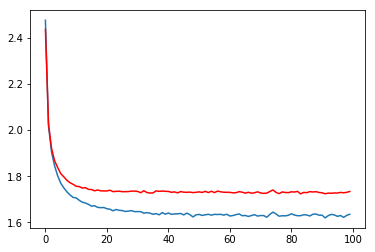

In [86]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [87]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Tho worthy proper it they wouldish Prossic.

SUFFOLK:
I your housed the scons.

KING OF SYRACUSEL:
These against the hore be gentle close to belike but it sir.

LUCIO GOLESSBAR:
Nay, than shalt Traise you the time enough in the lawer' in side how laves, sweet here them a most are he eny men,
This or undoble sweet of it leave, I make some coge first them.

LONY:
No, to meeirly, then at a father shall my deeige; I canns my sleep you another'd you deserve, this news tongue, and should
The gods this isest tongue, the majesting woon's condstant me, jolding.

Got to no harm his most speed have food in bases clear me, it is himsely nothing and save and do, the shamess! the setents, the deam sends, sell-siseth him;
Her place,
To shall we wild;
With come those dear
A thoughts in you should canst, and the father but hearfore
my thus haspon many have to his sinces to newsing for mind, rather see a owe is the fair well come the door it, here.

EXDOMO:
Good
she printor for his shall be have you he 

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

Training for 5000 epochs...
 6s (50 1%) train loss: 2.0127, test_loss: 2.0122]
Whempen on ever seat plomem's wead the to the kingent a prats whith creath of and fried if the plownes 

 11s (100 2%) train loss: 1.8285, test_loss: 1.8643]
What of more ling to the pleed
Tell mowns; where here's a preather me will he way, indo you kneave her 

 12s (150 3%) train loss: 1.7195, test_loss: 1.7510]
Whith a bound. Thou may
To courten is break dright, thou
greater, my will sait of charder: hous the ca 

 11s (200 4%) train loss: 1.6376, test_loss: 1.7059]
What well! Chere a gods sir, when me with e'er gone no no be not such one mover deathen bead by hath c 

 10s (250 5%) train loss: 1.6087, test_loss: 1.6444]
Who konget to bust again! to the sent we wene one wive to his fations to it, twat he will thee?

MISTR 

 12s (300 6%) train loss: 1.5618, test_loss: 1.6230]
What his brather's fool, it thou doth slaves with the timeth of me that my lord.

ROSALIND:
He shalt t 

 14s (350 7%) train loss: 

 27s (2600 52%) train loss: 1.3817, test_loss: 1.5186]
Wherefore, soard was with thee come to you?

DROMIO OF SYRACUSE:
I will say I have been converset, I h 

 26s (2650 53%) train loss: 1.3326, test_loss: 1.4578]
Where with their fleece;
I would not be high son that come to, with my lady,
Who will not lose your so 

 26s (2700 54%) train loss: 1.3604, test_loss: 1.4903]
Where har must not was to see a money, the madd oun in beast of my ear.

PERDITA:
In every millient, a 

 25s (2750 55%) train loss: 1.3443, test_loss: 1.4725]
Wherein must go in and work, ever whird have single season of our eyes still died, and then;
and be ha 

 25s (2800 56%) train loss: 1.3814, test_loss: 1.4732]
What you are went is of great Richard, for their beavers to the strumpet, I was she was been in the ca 

 24s (2850 56%) train loss: 1.3388, test_loss: 1.4844]
Which fall of this.

DUKE OF AUMERLE:
O excuse her.

BEATRICE:
In the gate words, to swears the spirit 

 23s (2900 57%) train loss: 1.3613, test

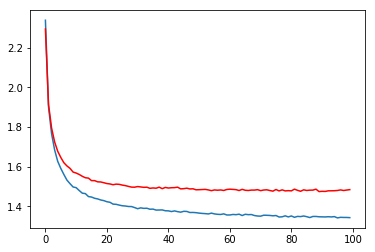

In [91]:
### 1 
### GRU

hidden_size = 400
learning_rate = 0.003


rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

In [93]:
### LSTM

rnn = RNN(n_characters, hidden_size, n_characters, model_type="lstm", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 5000 epochs...
 20s (50 1%) train loss: 2.0288, test_loss: 2.0391]
Whats abus will by of be wight is mast:
And tand whound the my wrow to the so. ir seare there thou sur 

 44s (100 2%) train loss: 1.7942, test_loss: 1.8189]
Whein as my should toon is disperice and the lie, and with worn and sheat of and the word he dond ther 

 41s (150 3%) train loss: 1.6899, test_loss: 1.6899]
Whis bechery, felling, this fastare.

ORLENCO:
How hath a have is here's not alaning partsale, to hope 

 59s (200 4%) train loss: 1.5836, test_loss: 1.6713]
Where a puretent.

ALETIA: My do such like ruint atward Cassian love him;
Get them that make of a all  

 10s (250 5%) train loss: 1.5174, test_loss: 1.6075]
When, my land
It is the juiner with all troan.

PROMPEY:

COSTALIND:
By jurdediad, and this earth,
But 

 23s (300 6%) train loss: 1.4529, test_loss: 1.5830]
Where and tell you mischipose
The world of eallest lack away.

Second Come,
An will that see they chan 

 36s (350 7%) train loss:

KeyboardInterrupt: 

In [ ]:
### RNN + extra layer
n_layers=3

rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))